# Определение токсичных комментариев с помощью нейронной сети

1. Ссылка на наше соревнование [HA: toxic comment classification](https://www.kaggle.com/c/ha-toxic-comment-classification?rvi=1).

2. Для создания векторов слов применим эмбеддинг [BPE](https://nlp.h-its.org/bpemb/),
используя предобученную модель.

3. Для решения задачи бинарной классификации (toxic / nontoxic) применим фреймворк [Flair](https://github.com/zalandoresearch/flair).
Flair - небольшой активно развивающийся фреймворк для некоторых задач NLP
(классификация текстов, NER), работающий поверх Pytorch.
С его помощью можно буквально за несколько строк собрать NLP-модель,
используя самые передовые технологии обработки естественного языка.


In [1]:
# установка библиотеки при необходимости
# !pip install flair

In [2]:
import os
import pandas as pd
import numpy as np
import re

from flair.data import Corpus
from flair.datasets import ClassificationCorpus
from flair.embeddings import BytePairEmbeddings
from flair.embeddings import DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.visual.training_curves import Plotter

from flair.data import Sentence

import matplotlib.pyplot as plt
from matplotlib import rcParams

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

plt.figure(figsize=(12, 6), dpi=100)
plt.style.use('bmh')

<Figure size 1200x600 with 0 Axes>

## 1. Анализ и подготовка датасета

In [3]:
df = pd.read_csv('simple_train.csv')

In [4]:
df.head(10)

# TODO: skip first column w/ id

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0
9,00040093b2687caa,alignment on this subject and which are contra...,0


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            159571 non-null  object
 1   comment_text  159571 non-null  object
 2   toxic         159571 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


<AxesSubplot:>

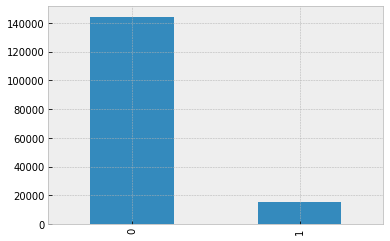

In [6]:
# Посмотрим на распределение нашего датасета
df.toxic.value_counts().plot.bar()

In [7]:
# Как видно из графика, наш датасет несбалансирован,
# что может отрицательно повлиять на качество
# обучения модели
df.toxic.value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [8]:
# Удалим часть данных с меткой 0, т.е. нетоксичных комментариев.
# Это хоть и уменьшит выборку, но сделает её более сбалансированной.
df = pd.concat([df[df.toxic == 0].sample(15294), df[df.toxic == 1]], ignore_index = True)

<AxesSubplot:>

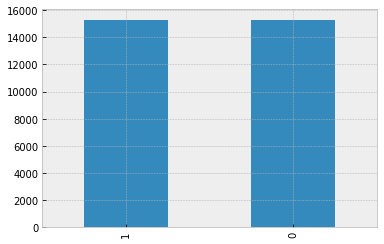

In [9]:
df.toxic.value_counts().plot.bar()

In [10]:
# посмотрим на облако слов
df_toxic_comment = df.comment_text[df.toxic==1]
df_toxic_comment.head()

15294         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
15295    Hey... what is it..\n@ | talk .\nWhat is it......
15296    Bye! \n\nDon't look, come or think of comming ...
15297    You are gay or antisemmitian? \n\nArchangel WH...
15298             FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
Name: comment_text, dtype: object

In [11]:
# объединим текст в строку
toxic_text = " ".join(txt for txt in df_toxic_comment)

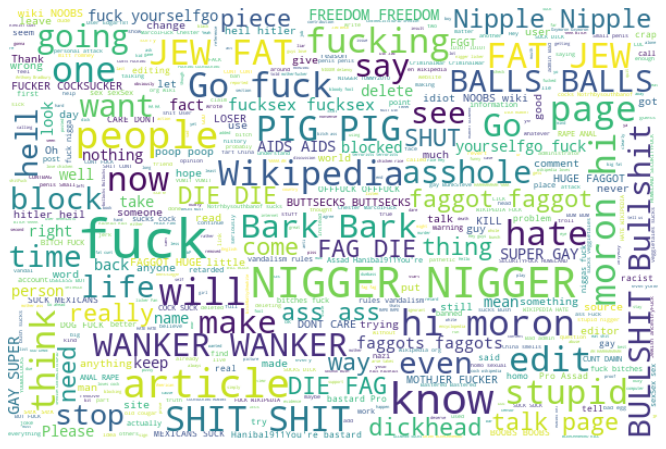

In [12]:
# построим облако слов
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=500,
                      width = 600, height = 400,
                      background_color="white").generate(toxic_text)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Подготовим текст:
1. Удалим переносы строк.
2. Оставим только буквенный текст (удалим знаки препинания, цифры и иные символы).
3. Приведём текст к нижнему регистру.

In [13]:
# все применяем к столбцу comment_text

df.comment_text = df.comment_text.str.replace('\n', ' ', regex=False)
# df.comment = df.comment.str.replace('ё', 'е', regex=False)
df.comment_text = df.comment_text.str.replace('[^a-zA-Zа-яА-Я]+', ' ')
df.comment_text = df.comment_text.str.lower()

Чтобы в ходе подбора оптимальной модели не производить манипуляции с датасетом, сохраним наши подготовленные данные.

Сохраним предподготовленный датасет в файлы формата [fasttext](https://fasttext.cc/).
Это текстовый файл, в котором сохранены предобработанные тексты с меткой класса -
для различных классификаций текстов.

Первым параметром идёт метка, начинающаяся со служебного слова `__label__`.

Например, так: `__label__mark` или так: `__label__0`.

Затем через пробел идёт сам предобработанный текст.
Каждый элемент датасета начинается с новой строки.

Для этого преобразуем признак `toxic`. И поменяем колонки местами.

In [14]:
df.toxic = '__label__' + df.toxic.apply(str)
df = df.reindex(columns=['toxic', 'comment_text'])
df.sample(5)

,toxic,comment_text
8363,__label__0,when does micro cadam become helix design sys...
19405,__label__1,nazism and religion nazi mysticism nazi archit...
903,__label__0,you live in vegas hit
1711,__label__0,actually i kind of forgot about the icon usage...
16344,__label__1,it s no use i didnt even get a chance to add l...


Разбиваем предобработанный датасет на три выборки:
* обучающую
* валидационную
* тестовую

In [15]:
# https://stackoverflow.com/a/38251063
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [16]:
train, validate, test = train_validate_test_split(df, train_percent=.7, validate_percent=.2, seed=700)
train.shape[0], validate.shape[0], test.shape[0]

(21411, 6117, 3060)

In [17]:
print('done')

done


In [18]:
# если директория files/ не создана, создать ее
if not os.path.exists('files'):
    os.makedirs('files')

In [19]:
# os.chdir('files/')

In [20]:
# if not os.path.exists('fasttext'):
#     os.makedirs('fasttext')

In [21]:
file_path = 'files/'
train.to_csv(file_path+'toxic.train.fasttext',
             sep=' ',
             index=False,
             header=None)
validate.to_csv(file_path+'toxic.validate.fasttext',
                sep=' ',
                index=False,
                header=None)
test.to_csv(file_path+'toxic.test.fasttext',
            sep=' ',
            index=False,
            header=None)

In [22]:
print('done')

done


# 3. Создание и тренировка модели

Мы не будем создавать собственный словарь и собственные вектора слов, а будем использовать уже готовые модели.

Для [эмбеддинга](https://www.nkj.ru/open/36052/) мы возьмём модель **BPE** - [Byte Pair Embeddings](https://nlp.h-its.org/bpemb/).

Во-первых, если мы будем использовать свой словарь - словарь, основанный на словах из нашего датасета,
то всегда есть возможность, что в процессе использования модели ей встретится незнакомое слово.

Во-вторых, уже существующие полнословные словари слишком большие.

В-третьих, с помощью модели BPE мы будем учитывать возможные опечатки в тексте
и жаргонную лексику, а это очень распространённое явление в пользовательских комментариях в соцсетях. Такая модель, как, например, FastText тоже умеет учитывать не встречающиеся в её словаре слова, но она слишком большая - всё это (в частности для русского языка) из-за того, что слова в словаре были некачественно предобработаны.


# Загружаем подготовленный датасет
# Для более быстрой обработки информации можно весь датасет поместить в 
# оперативную память. Для этого выставляем флаг: in_memory=True
# data_folder = '/model/'

corpus: Corpus = ClassificationCorpus(
    # data_path, # папка, в которой расположены файлы датасета
    train_file='toxic.train.fasttext', # данные для обучения модели
    dev_file='toxic.validate.fasttext', # данные для валидации модели
    test_file='toxic.test.fasttext', # тестовые данные, не участвующие в ходе обучения
    in_memory=True
    )

In [23]:
# Загружаем подготовленный датасет
# Для более быстрой обработки информации можно весь датасет поместить в 
# оперативную память. Для этого выставляем флаг: in_memory=True
# data_folder = '/model/'

corpus: Corpus = ClassificationCorpus(
    file_path, # папка, в воторой расположены файлы датасета
    train_file='toxic.train.fasttext', # данные для обучения модели
    dev_file='toxic.validate.fasttext', # данные для валидации модели
    test_file='toxic.test.fasttext' # тестовые данные, не участвующие в ходе обучения
    # in_memory=True
    )

2020-10-09 02:16:48,596 Reading data from files
2020-10-09 02:16:48,598 Train: files/toxic.train.fasttext
2020-10-09 02:16:48,615 Dev: files/toxic.validate.fasttext
2020-10-09 02:16:48,617 Test: files/toxic.test.fasttext


In [24]:
# Проверим загруженные данные
print(len(corpus.train), len(corpus.dev), len(corpus.test), sep=', ')

21411, 6117, 3060


In [25]:
# Наши метки
# 0 - нетоксичный комментарий, 1 - токсичный
label_dict = corpus.make_label_dictionary()

2020-10-09 02:16:49,682 Computing label dictionary. Progress:
2020-10-09 02:17:45,485 [b'1', b'0']


100%|██████████| 24471/24471 [00:35<00:00, 693.66it/s]


Как говорилось выше, мы используем BPE в качестве эмбеддинга. Параметры же нашей нейронки таковы:

Мы используем 2 слоя двунаправленной сети [GRU](https://ru.wikipedia.org/wiki/Управляемый_рекуррентный_блок) со скрытым слоем, равным 124. Сеть GRU - это вариации рекуррентной нейронной сети LSTM. Реккурентные нейронные сети зарекомендовали себя, как хороший обработчик последовательностей. Тексты - это как раз последовательности.

Двунаправленность используется в связи с тем, что в предложении русского языка нет чёткой последовательности слов (*кот ушёл* и *ушёл кот*), поэтому наша сеть будет проходить предложение как с начала, так и с конца, чтобы лучше понять его.


In [26]:
# Инициализируем эмбеддинг на основе BPE
bp_embedding = BytePairEmbeddings('en')

In [27]:
# Далее задаём параметры нейронной сети.
document_emb = DocumentRNNEmbeddings(
    [bp_embedding],
    hidden_size=128,
    reproject_words=True, # трансформируем входящий вектор
    reproject_words_dimension=256,
    rnn_layers=2,
    bidirectional=True,
    dropout=0.2,
    word_dropout=0.2,
    rnn_type='GRU')

In [28]:
# Инициализируем текстовый классификатор
classifier = TextClassifier(document_emb, label_dictionary=label_dict)
# По умолчанию в качестве оптимизатора используется SGD.
# Мы будем использовать его, поэтому не указываем явно тип оптимизатора:
trainer = ModelTrainer(classifier, corpus)

# Если же нужно использовать какой-то иной алгоритм, его нужно указать:
#
# from torch.optim.adam import Adam
# trainer = ModelTrainer(classifier, corpus, optimizer=Adam)

# По умолчанию данный фреймворк использует GPU. Если GPU нет, фреймворк сам 
# выбирает CPU.
# Если для обучения используется CPU, можно указать количество процессоров
trainer.num_workers = 15
#
# Что используется на данный момент, можно узнать, выполнив слудующий код:
# import flair
# print(flair.device)

In [29]:
# ?flair.ModelTrainer

In [30]:
os.chdir('files')

In [31]:
if not os.path.exists('model'):
    os.makedirs('model')

In [32]:
os.getcwd()

'/Users/sergeyilyin/CodeProjects/learn_ml_in_cbr/ml_linear_models/toxic_comment_competition/files'

In [ ]:
# Начинаем тренировку
# Можно указывать сколько угодно много эпох, а потом, когда модель будет 
# достаточно обучена, остановить выполнение кода. Фреймворк поймёт, что
# надо прекратить обучение,- остановится, пересчитает все веса. Но даже если
# не останавливать принудительно модель, то фреймворк увидит, когда уже нет
# возможности делать модель лучше, и тоже остановит обучение.
# и сохранит наилучший результат в файл best_model.pt
#
# не обязательно делать слишком маленький learning_rate.
# При необходимости фреймворк сам его уменьшит.
trainer.train(
    'model/',
    learning_rate=0.1,  
    mini_batch_size=64,
    anneal_factor=0.5,
    patience=5,
    max_epochs=30,
    monitor_train=True)

2020-10-09 02:17:46,815 ----------------------------------------------------------------------------------------------------
2020-10-09 02:17:46,834 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): BytePairEmbeddings(model=0-bpe-en-100000-50)
    )
    (word_reprojection_map): Linear(in_features=100, out_features=256, bias=True)
    (rnn): GRU(256, 128, num_layers=2, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (word_dropout): WordDropout(p=0.2)
  )
  (decoder): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): CrossEntropyLoss()
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2020-10-09 02:17:46,849 ----------------------------------------------------------------------------------------------------
2020-10-09 02:17:46,852 Corpus: "Corpus: 21411 train + 6117 dev + 3060 test sentences"
2020-10-09 02:17:46,853 ----------------------

## 4. Использование модели.

Я остановил тренировку после 5-й эпохи. Результаты лучшей модели таковы:

* Accuracy: 75%
* F1: 86%

Естественно, можно попытаться улучшить качество модели, изменяя параметры и гиперпараметры, а также увеличив количество эпох тренировки.

На заключительном этапе посмотрим: 
* как обучалась модель;
* как загрузить лучшую модель;
* как использовать сохранённую модель.

In [43]:
os.getcwd()

'/Users/sergeyilyin/CodeProjects/learn_ml_in_cbr/ml_linear_models/toxic_comment_competition/files'

In [44]:
# Построим график обучения модели
plotter = Plotter()
plotter.plot_training_curves('model/loss.tsv')
# Сохранённый график обучения модели ищите в этой же папке.
# Название файла: training.png

TypeError: argument of type 'NoneType' is not iterable

<Figure size 1080x720 with 0 Axes>

In [52]:
# Загружаем модель для использования
model = TextClassifier.load('/content/drive/My Drive/colab_data/toxic/model/best-model.pt')

2019-08-26 08:54:28,926 loading file /content/drive/My Drive/colab_data/toxic/model/best-model.pt


In [53]:
# Сколько параметров у нашей модели
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'В ходе тренировки модели было использовано {count_parameters(model):,} параметров.')

В ходе тренировки модели было использовано 224,514 параметров.


Для того, чтобы получить результат не для целого датасета, а для одного предложения, в фреймворке Flair имеется `Sentence`.

In [0]:
# Предобработка единичного комментария
# Те же самые операции, что мы производили над датасетом,
# только теперь для единичного комментария.
def preprocess_text(text):
  text = text.replace('\n', ' ')
  text = text.replace('ё', 'е')
  text = re.sub('[^a-zA-Zа-яА-Я]+', ' ', text).lower()
  return text.strip()

In [63]:
# создаём экземпляр Sentence и передаём его нашей модели
t = 'Да вы все ёбаные пидарасы!'

sentence = Sentence(preprocess_text(t))
model.predict(sentence)

print(sentence.labels)

[1 (0.8408752679824829)]


**Великолепно!**

Модель нам верно указала, что данный комментарий является токсичным (метка 1).

Вероятность токсичности комментария: 84%.